In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time as time
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from xgboost import XGBClassifier


# from make_model import make_model
import sys
path = os.getcwd()
sys.path.append(path+'/scripts')
import param_grids
from make_model_3 import make_model_l, make_model_nl

In [3]:
data = path + '/dataset/bank/bank-additional/bank-additional-full.csv'
df_orig = pd.read_csv(data, sep=';')
print(f'size of the data --> {df_orig.shape}')
df_orig.head()

size of the data --> (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# create table listing column types etc
df = df_orig.copy()        # make a copy of the data before any transformations

df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'Duplicates dropped --> {df.duplicated().sum()}')
# drop duplicates, 12 rows
df = df.drop_duplicates()
df_info

Duplicates dropped --> 12


,column,dtype,NA_count,unique_count
0,age,int64,0,78
1,job,object,0,12
2,marital,object,0,4
3,education,object,0,8
4,default,object,0,3
5,housing,object,0,3
6,loan,object,0,3
7,contact,object,0,2
8,month,object,0,10
9,day_of_week,object,0,5


### Decision Trees

- Tuned hyperparameters have been found in feature_selection.ipynb
- Update hyperparameters in param_grids.py or manually in this notebook
- Compare Decision Tree model with ensemble models using DecisionTreeClassifier

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.9352528743508758
Training Time : 4 minutes
Test Score : 0.936145793136071


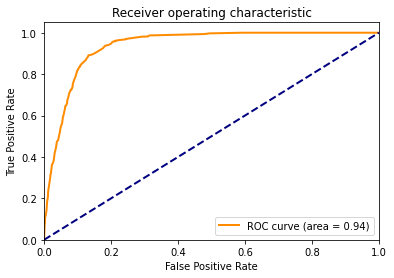

In [4]:
random_state = 42
folds = 5
model_name = f'new_dt_{folds}'
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

df = df_orig.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Accuracy : 0.9411113333790174
Training Time : 0 minutes
Test Score : 0.9363867021171434


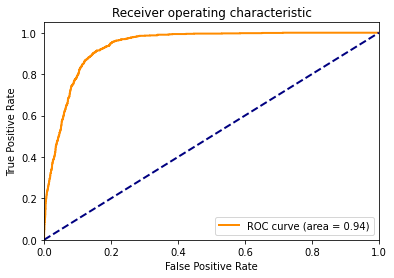

In [5]:
random_state = 42
folds = 5
model_name = f'new_rf_{folds}'
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_rf

df = df_orig.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### AdaBoost

Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.9323155462864456
Training Time : 1 minutes
Test Score : 0.9307437204401384


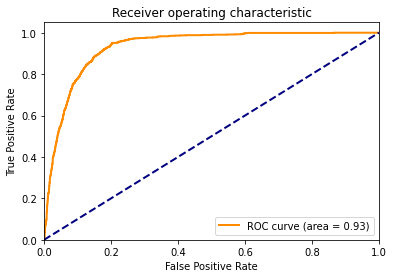

In [6]:
random_state = 42
folds = 5
model_name = f'new_ada_{folds}'
model = AdaBoostClassifier(random_state=random_state)
parameters = param_grids.param_ada

df = df_orig.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### XGBoost

Tuned Hyperparameters : {'classifier__booster': 'gbtree', 'classifier__eval_metric': 'auc', 'classifier__gamma': 0.2, 'classifier__max_depth': 6}
Accuracy : 0.9455703582904814
Training Time : 4 minutes
Test Score : 0.946265141934931


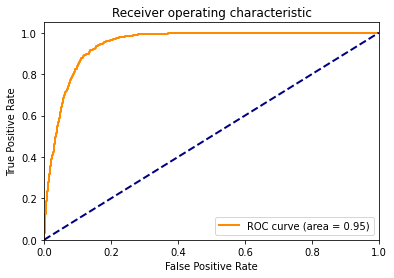

In [7]:
random_state = 42
folds = 5

model_name = f'new_xgb_{folds}'
model = XGBClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_xgb  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_orig.copy()

# Replace 'no' and 'yes' with 0 and 1, respectively
df['y'] = df['y'].map({'no': 0, 'yes': 1})

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Bagging

Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.8989205163045044
Training Time : 0 minutes
Test Score : 0.9031037717266583


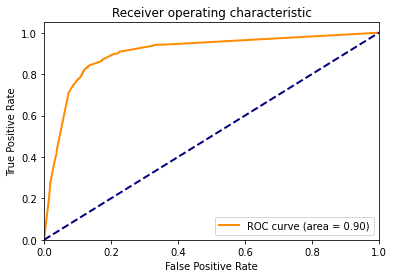

In [8]:
random_state = 42
folds = 5

model_name = f'new_bag_{folds}'
model = BaggingClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_bag  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_orig.copy()

# Replace 'no' and 'yes' with 0 and 1, respectively
df['y'] = df['y'].map({'no': 0, 'yes': 1})

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


- BaggingClassifier gives better estimates when using LogisticRegression as base estimator.

Training DecisionTree...
Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.9357430096935726
Training Time : 4 minutes
Test Score : 0.9345954816019497


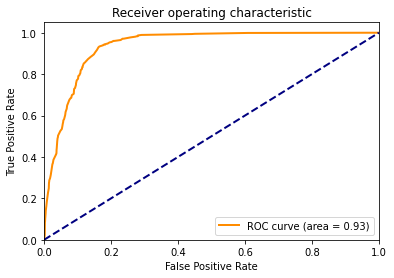

Training RandomForest...
Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Accuracy : 0.938889654136525
Training Time : 0 minutes
Test Score : 0.9397811023379886


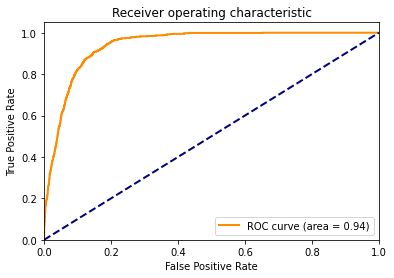

Training AdaBoost...
Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.9319968648688807
Training Time : 1 minutes
Test Score : 0.9285562083123118


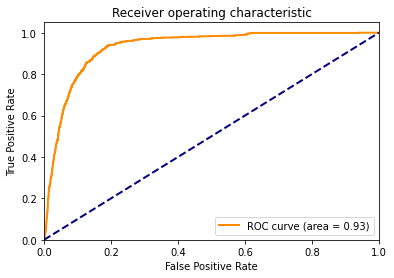

Training XGBoost...


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['no' 'yes']

In [12]:
import param_grids as param_grids
random_state = 42
folds = 5

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=random_state),
    'RandomForest': RandomForestClassifier(random_state=random_state),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state),
    'BaggingClassifier': BaggingClassifier(random_state=random_state)
}

parameters = {
    'DecisionTree': param_grids.param_dt,
    'RandomForest': param_grids.param_rf,
    'AdaBoost': param_grids.param_ada,
    'XGBoost': param_grids.param_xgb,
    'BaggingClassifier': param_grids.param_bag
}

results = []
df = df_orig.copy()
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name == 'XGBoost':
        df['y'] = df['y'].map({'no': 0, 'yes': 1})
    clf_grid, time, test_score = make_model_nl(df, model, parameters[model_name], test_size=0.2, folds=folds)
    
    # Save the model to disk
    pickle.dump(clf_grid, open(f'trained_models/tuned_{model_name}.pkl', 'wb'))

    results.append({
        'Model': model_name,
        'Training Time (min)': time,
        'Test Score': test_score,
        'Best Hyperparameters': clf_grid.best_params_
    })

# Convert results to a pandas DataFrame and display the table
results_df = pd.DataFrame(results)
display(results_df)